## Data exploration:
Creating a feature vector for each text, based on the mean w2v, gene and variation.
using random forests to check for accuracy; gene and variation didn't really improve results
due to their sparse occurence (see the cancer_stats notebook). Further feature extraction from
genes and variations might help however.
Here better regex rules are applied to account for different notation and not to mess up gene names that consist of letters and numbers

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier

import itertools
from gensim.models import Word2Vec, KeyedVectors
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
stop_words = stopwords.words('english') + \
            ['et', 'al', 'fig', 'figs', 'figure', 'table', 'also',
            'using', 'found', 'observed', 'however', 'previous', 'study',
            'although', 'studies', 'several', 'showed', 'could', 
            'performed', 'known', 'methods', 'whether', 'materials',
            'known', 'analyzed', 'within', 'show', 'respectively', 
            'thus', 'therefore', 'tested', 'among', 'abstract', 
            'introduction', 'may', 'shown', 'results', 'interestingly',
            'either', 'similarly', 'furthermore', 'consistently', 
            'neither', 'one', 'two', 'three', 'four', 'five', 'six',
            'seven', 'eigh', 'nine', 'ten', 'eleven', 'twelve', 
            'thirteen', 'fourteen', 'fifteen', 'sixteen', 'seventeen',
            'eighteen', 'nineteen', 
            'supplemental', 'almost', 'generally', 'underlying', 'play',
            'pivotal', 'remain', 'whose',
            'finally' , 'name', 'albeit', 'notably', 'corresponding', 'used', 'obtained', 'total', 'panel', 'seen',
'left', 'right', 'another', 'ability', 'significantly', 'upon', 'observations', 'detecting', 'unveil',
'hypothesized', 'yet', 'whereas', 'capture', 'middle', 'determined', 'added', 'amounts', 'visualized',
'bottom', 'involved', 'aim', 'highly', 'specific', 'caused', 'marked', 'suggest', 'expected', 'combined', 
'wished', 'explore', 'hypothesis', 'dramatically', 'involves', 'verified', 'proper', 'existence',
'finding', 'establish', 'direct', 'previously', 'mediated', 'remained', 'directly', 'studied', 'indeed',
'individual', 'robustly', 'suggests', 'important', 'supported', 'seem', 'judged', 'much', 'hence',
'regardless', 'must', 'seems', 'findings', 'achieved', 'offer', 'explanation', 'already', 'evidence',
'reported', 'bring', 'usual', 'so-called', 'fashion', 'especially', 'would', 'allow', 'require', 'present',
'first', 'frequently', 'many', 'contribute', 'understanding', 'causing', 'like', 'third', 
'interesting', 'showing', 'various', 'certain', 'particular', 'general', 'described', 'according',
'manufacturers', 'instructions', 'scientific', 'content', 'times', 'page', 'onto', 'processed',
'standard', 'procedures', 'following', 'primary', 'biotechnology', 'generated', 'system', 'provider',
'infected', 'infection', 'time', 'see', 'supplementary', 'note', 'online', 'authors',
'noted', 'represented', 'define', 'apparent', 'appearance', 'cases', 'recognizable', 'case', '4th', '5th',
'right', 'compare', 'picture', 'data', 'log2', 'represents', 'full', 'ref',
'high-resolution', 'real-time', 'defined', 'find', 'proven', 'routine', 'databases', 'literature',
'remaining', 'affecting',
             'whose', 'elusive', 'reveal', 'plays', 'ago', 'others', 'presents', 'correspond', 
'corresponds', 'examined', 'detected', 'straightforward', 'reproducible', 'relevance',
'demonstrating', 'suggested', 'exhibited', 'suggesting', 'likely', 
 #           'mutation', 'cell', 'mutations', 'cells',
            ]


In [4]:
sp  = re.compile(r'(?<!-)\b(' + r'|'.join(stop_words) + r')\b(?!-)\s*')
s = sp.sub(' x ', 'a Fromage amk ia hla-a a one I a i one 2a')
#s = sp.sub(' x ', s)
s

' x Fromage amk ia hla-a  x  x I  x  x  x 2a'

In [5]:
#stop_pattern = re.compile(r'\b(' + r'|'.join(stop_words) + r')\b\s*')
stop_pattern = re.compile(r'(?<!-)\b(' + r'|'.join(stopwords.words('english')+stop_words) + r')\b(?!-)\s*')

def get_cleaned_text(fname, max_len=999999):
    all_words = []
    with open(fname, 'r') as f:
        for n, line in enumerate(f):
            if n and n<max_len:
                line_id, line_text = line.split('||')
                # this regex should remove all the lone numbers, i.e, numbers that are not part of words
                #line_text = re.sub(r"$\d+\W+|\b\d+\b|\W+\d+$", " ", line_text) 
                line_text = re.sub(r"(?<!-)\b\d+\b", " ", line_text)
                # keep letters, numbers and a few characters that are seen in words;
                # substitute other characters with a space
                line_text = re.sub("[^\w\-\*\_]", " ", line_text)
                #line_text = re.sub("[\s.,()\'\`\"\’\‘]", " ", line_text)
                #print(line_text)        
                #line_text = re.sub("[^\w\-\*\_]", " ", line_text)

                line_letters_low = line_text.lower()
                line_letters_low = stop_pattern.sub(' ', line_letters_low)
                line_words = line_letters_low.split()
                line_words = [s for s in line_words if len(s) > 2]
                all_words.append(line_words)
                #all_words.append(line_letters_low)
                #print(len(all_words), len(line_letters_low))
    return all_words

In [6]:
def get_wv():
    fname = '../data/training_text'
    train_text = get_cleaned_text(fname)
    fname = '../data/test_text'
    test_text = get_cleaned_text(fname)
    test_text.extend(train_text)
    
    w2v_model = Word2Vec(test_text, size=200, window=5, min_count=3, workers=4, iter=10)
    return w2v_model

In [7]:
w2v_model = get_wv()

In [8]:
w2v_model.wv['fam58a']
w2v_model.wv.most_similar(positive='gene')

[('genes', 0.7782886028289795),
 ('locus', 0.5538582801818848),
 ('loci', 0.4752123951911926),
 ('oncogene', 0.4645266830921173),
 ('oncogenes', 0.44527050852775574),
 ('intragenic', 0.44102710485458374),
 ('chromosome', 0.4373520612716675),
 ('11p15', 0.4294061064720154),
 ('mrna', 0.4284912049770355),
 ('genomic', 0.4276922941207886)]

In [9]:
def get_feature_vector(fname_text, variants):
    text = get_cleaned_text(fname_text)

    text_wv_mean = np.empty(shape=(len(text), w2v_model.layer1_size))
    gene_wv_mean = np.zeros(shape=(len(text), w2v_model.layer1_size))
    vari_wv_mean = np.zeros(shape=(len(text), w2v_model.layer1_size))
    for i, text in enumerate(text):
        # as a first approximation, let's estimate the mean vector of each text;
        # for later TODO some fancy projections
        text_wv_mean[i, :] = np.array([w2v_model.wv[w] for w in text if w in w2v_model.wv.vocab]).mean(axis=0)
        if variants['Gene'][i] in w2v_model.wv.vocab:
            gene_wv_mean[i, :] = w2v_model.wv[variants['Gene'][i].lower()]
        # some parsing of the variation names will be good
        if variants['Variation'][i] in w2v_model.wv.vocab:
            vari_wv_mean[i, :] = w2v_model.wv[variants['Variation'][i].lower()]
    return np.concatenate((text_wv_mean, gene_wv_mean, vari_wv_mean), axis=1)


train_variants = pd.read_csv('../data/training_variants')
fvec = get_feature_vector('../data/training_text', train_variants)
fvec.shape

(3321, 600)

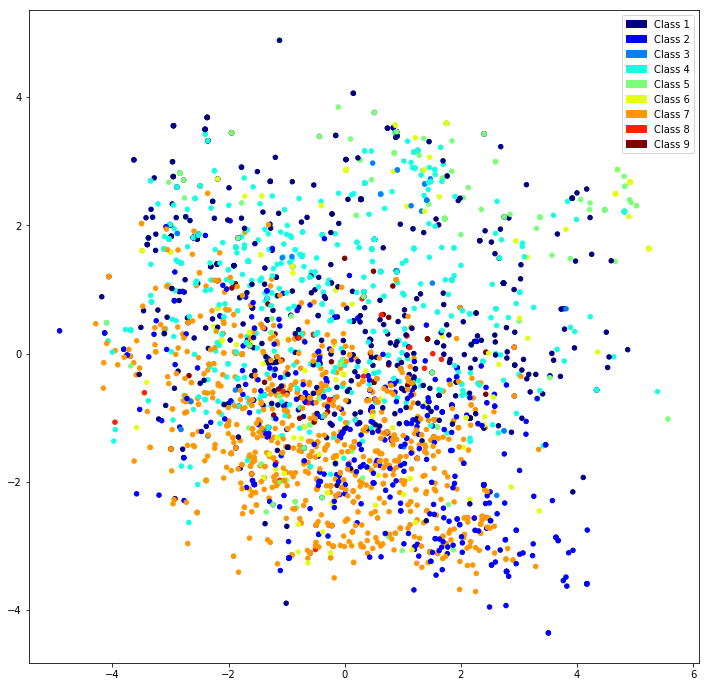

In [10]:
from matplotlib.patches import Patch

pca = PCA(n_components=2)
reduced_vecs = pca.fit_transform(fvec)
classes = train_variants.Class.values

fig = plt.figure(figsize=(12,12))
ax = plt.subplot(111)
cm = plt.get_cmap('jet', 9)
colors = [cm(i/9) for i in range(9)]
ax.scatter(reduced_vecs[:,0], reduced_vecs[:,1], c=[colors[c-1] for c in classes], cmap='jet', s=20)
#plt.legend(['Class ' +str(i+1) for i in range(9)])
plt.legend(handles=[Patch(color=colors[i], label='Class {}'.format(i+1)) for i in range(9)])

In [11]:
forest = RandomForestClassifier(n_estimators=300, class_weight="balanced", n_jobs=2) 
forest = forest.fit(fvec, train_variants["Class"])

result_tr = forest.predict(fvec)
print("corr between prediction and real: ", np.corrcoef(result_tr, np.array(train_variants["Class"]))[0,1])

scores = cross_val_score(forest, fvec, train_variants["Class"], cv=10, n_jobs=2)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

corr between prediction and real:  0.862925685327
[ 0.4375      0.46428571  0.37724551  0.43543544  0.32132132  0.45783133
  0.56797583  0.62424242  0.59270517  0.42201835]
Accuracy: 0.47 (+/- 0.09)


In [12]:
forest = RandomForestClassifier(n_estimators=20, class_weight="balanced", n_jobs=2) 
forest = forest.fit(fvec, train_variants["Class"])

result_tr = forest.predict(fvec)
print("corr between prediction and real: ", np.corrcoef(result_tr, np.array(train_variants["Class"]))[0,1])

scores = cross_val_score(forest, fvec, train_variants["Class"], cv=10, n_jobs=2)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

corr between prediction and real:  0.858630545075
[ 0.46130952  0.45238095  0.4011976   0.37837838  0.36036036  0.4246988
  0.50453172  0.6         0.57142857  0.44342508]
Accuracy: 0.46 (+/- 0.07)


In [13]:
forest = RandomForestClassifier(n_estimators=50, class_weight="balanced", n_jobs=2) 
forest = forest.fit(fvec, train_variants["Class"])

result_tr = forest.predict(fvec)
print("corr between prediction and real: ", np.corrcoef(result_tr, np.array(train_variants["Class"]))[0,1])

scores = cross_val_score(forest, fvec, train_variants["Class"], cv=10, n_jobs=2)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

corr between prediction and real:  0.858973411513
[ 0.4047619   0.44642857  0.44311377  0.41441441  0.33033033  0.42771084
  0.54380665  0.61818182  0.55319149  0.41590214]
Accuracy: 0.46 (+/- 0.08)


In [14]:
forest = RandomForestClassifier(n_estimators=100, class_weight="balanced", n_jobs=2) 
forest = forest.fit(fvec, train_variants["Class"])

result_tr = forest.predict(fvec)
print("corr between prediction and real: ", np.corrcoef(result_tr, np.array(train_variants["Class"]))[0,1])

scores = cross_val_score(forest, fvec, train_variants["Class"], cv=10, n_jobs=2)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

corr between prediction and real:  0.861359803147
[ 0.39583333  0.46130952  0.43712575  0.43843844  0.34834835  0.44578313
  0.55589124  0.62121212  0.58966565  0.42813456]
Accuracy: 0.47 (+/- 0.08)


In [15]:
forest = RandomForestClassifier(n_estimators=200, class_weight="balanced", n_jobs=2) 
forest = forest.fit(fvec, train_variants["Class"])

result_tr = forest.predict(fvec)
print("corr between prediction and real: ", np.corrcoef(result_tr, np.array(train_variants["Class"]))[0,1])

scores = cross_val_score(forest, fvec, train_variants["Class"], cv=10, n_jobs=2)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

corr between prediction and real:  0.862134906958
[ 0.41666667  0.48214286  0.43113772  0.43843844  0.32732733  0.46084337
  0.54984894  0.62121212  0.57446809  0.42507645]
Accuracy: 0.47 (+/- 0.08)


In [16]:
forest = RandomForestClassifier(n_estimators=500, class_weight="balanced", n_jobs=2) 
forest = forest.fit(fvec, train_variants["Class"])

result_tr = forest.predict(fvec)
print("corr between prediction and real: ", np.corrcoef(result_tr, np.array(train_variants["Class"]))[0,1])

scores = cross_val_score(forest, fvec, train_variants["Class"], cv=10, n_jobs=2)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

corr between prediction and real:  0.863143620388
[ 0.41369048  0.4672619   0.39221557  0.45645646  0.34834835  0.44879518
  0.55287009  0.62424242  0.59270517  0.43730887]
Accuracy: 0.47 (+/- 0.08)


In [17]:
forest = RandomForestClassifier(n_estimators=500, n_jobs=2) 
forest = forest.fit(fvec, train_variants["Class"])

result_tr = forest.predict(fvec)
print("corr between prediction and real: ", np.corrcoef(result_tr, np.array(train_variants["Class"]))[0,1])

scores = cross_val_score(forest, fvec, train_variants["Class"], cv=10)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

corr between prediction and real:  0.876367035725
[ 0.4047619   0.48214286  0.4491018   0.42342342  0.33633634  0.43072289
  0.50755287  0.61212121  0.57142857  0.43730887]
Accuracy: 0.47 (+/- 0.08)


In [18]:
#test_text = get_cleaned_text(fname)
test_variants = pd.read_csv('../data/test_variants')
fvec_test = get_feature_vector('../data/test_text', test_variants)


In [19]:
result = forest.predict(fvec_test)
result_mat = np.zeros((len(result), 9))
    
test_id = np.arange(len(result))

result_mat[test_id, result-1] = 1
result_mat = result_mat.astype(int)
output = pd.DataFrame( data={"ID":test_id, "class1":result_mat[:,0],
        "class2":result_mat[:,1],
        "class3":result_mat[:,2],
        "class4":result_mat[:,3],
        "class5":result_mat[:,4],
        "class6":result_mat[:,5],
        "class7":result_mat[:,6],
        "class8":result_mat[:,7],
        "class9":result_mat[:,8]
        } )
output.to_csv( "w2v_on_text_genes_vars.csv", index=False)

In [23]:
clf = SGDClassifier(loss='hinge', penalty='l1')
scores = cross_val_score(clf, fvec, train_variants["Class"], cv=10)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

[ 0.34821429  0.35416667  0.40419162  0.32132132  0.24024024  0.3313253
  0.46827795  0.55757576  0.44072948  0.28440367]
Accuracy: 0.38 (+/- 0.09)
